<a href="https://colab.research.google.com/github/xhorn-pan/xhorn-pan/blob/main/final_vgg_cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Variational Autoencoder

## Env prepare

In [ ]:
!pip uninstall -y tensorflow-gpu tensorflow 
!pip install -q tf-nightly


In [ ]:
!pip uninstall -y tf-nightly
!pip install tensorflow-gpu

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

## Import TensorFlow and other libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
%load_ext tensorboard
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt

#logdir = "/content/drive/My Drive/Colab Notebooks/vgg-logs"
# logdir = "./vgg-logs"
# writer = tf.summary.create_file_writer(logdir)

TensorFlow 2.x selected.


In [ ]:
import pathlib
files_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/vggface2_test_64x64.zip")
data_dir = "./ds_vgg"
import zipfile
with zipfile.ZipFile(files_root, 'r') as zip_ref:
  zip_ref.extractall(data_dir)

## Load the vgg dataset

In [ ]:
data_root = pathlib.Path(data_dir + "/test")
all_faces_paths = list(data_root.glob("*/*"))#[0::2]
#all_faces_paths = all_faces_paths[0::2]
all_faces_paths = [str(path) for path in all_faces_paths]


train_dataset = [path for i, path in enumerate(all_faces_paths) if i % 10 != 0]
test_dataset = [path for i, path in enumerate(all_faces_paths) if i % 10 == 0]

trs, ts = len(train_dataset), len(test_dataset)
batch_size = 1024
AUTOTUNE = tf.data.experimental.AUTOTUNE

#load dataset
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  #image = (tf.cast(image, tf.float32) - 127.5) / 127.5 # normalize to [-1,1] range
  image = tf.cast(image, tf.float32) / 255.0

  #image[image >= .5] = 1.
  #image[image < .5] = 0.
  image = tf.math.round(image)

  return image

train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache()
train_dataset = train_dataset.shuffle(buffer_size=trs).batch(batch_size,
                           drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache()
test_dataset = test_dataset.shuffle(buffer_size=trs).batch(batch_size,
                           drop_remainder=True).prefetch(buffer_size=AUTOTUNE)



## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

# New Section

In [ ]:
k_initializer = tf.initializers.TruncatedNormal(stddev=0.02)
drop_rate = 0.3
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
          #tf.keras.layers.Conv2D(
          #    filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, 
              #strides=(2, 2), 
              padding="SAME", 
              #kernel_initializer=k_initializer, 
              activation='relu'),
          #tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, 
              #strides=(2, 2), 
              padding="SAME", 
              #kernel_initializer=k_initializer, 
              activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
          tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Conv2D(
              filters=128, kernel_size=3, 
              #strides=(2, 2), 
              padding="SAME", 
              #kernel_initializer=k_initializer, 
              activation='relu'),
          #tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Conv2D(
              filters=128, kernel_size=3, 
              #strides=(2, 2), 
              padding="SAME", 
              #kernel_initializer=k_initializer, 
              activation='relu'),
          #tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
          tf.keras.layers.Dropout(drop_rate),
          # tf.keras.layers.Conv2D(
          #     filters=256, kernel_size=3, 
          #     #strides=(2, 2), 
          #     padding="SAME", 
          #     kernel_initializer=k_initializer, activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Dense(units=4*4*256, activation=tf.nn.leaky_relu),
          tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
          tf.keras.layers.Conv2DTranspose(
              filters=256,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              #kernel_initializer=k_initializer,
              activation=tf.nn.leaky_relu),
          #tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.UpSampling2D(), # .MaxPooling2D(pool_size=(2, 2)),
          tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=3,
              #strides=(2, 2),
              padding="SAME",
              #kernel_initializer=k_initializer,
              activation=tf.nn.leaky_relu),
          #tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=3,
              #strides=(2, 2),
              padding="SAME",
              #kernel_initializer=k_initializer,
              #ivation='relu'),
              activation=tf.nn.leaky_relu),
          #tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.UpSampling2D(), # .MaxPooling2D(pool_size=(2, 2)),
          tf.keras.layers.Dropout(drop_rate),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              #strides=(2, 2),
              padding="SAME",
              #kernel_initializer=k_initializer,
              activation=tf.nn.leaky_relu),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              #strides=(2, 2),
              padding="SAME",
              #kernel_initializer=k_initializer,
              activation=tf.nn.leaky_relu),
          tf.keras.layers.UpSampling2D(), # .MaxPooling2D(pool_size=(2, 2)),
          tf.keras.layers.Dropout(drop_rate),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
  @tf.function
  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits


In [ ]:
latent_dim = 512
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
noise = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
model.generative_net.summary()
model.inference_net.summary()
tf.keras.utils.plot_model(model.generative_net, to_file="genertive.png", show_shapes=True, show_layer_names=False)
tf.keras.utils.plot_model(model.inference_net, to_file="inference.png", show_shapes=True, show_layer_names=False)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)#.numpy()
  #predictions = (predictions + 1.0) / 2.0
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('/content/drive/My Drive/ml_logs/vae_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
generate_and_save_images(model, 0, noise)

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
    #tf.summary.scalar("loss", loss, description=None)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [ ]:
#generate_and_save_images(model, 0, random_vector_for_generation)
elbo_hist = []
loss_hist = []
epochs = 100
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    print('.', end='')
    cag_loss = compute_apply_gradients(model, train_x, optimizer)
    loss_hist.append(cag_loss)
  print('')
  #tf.summary.trace_on(graph=True)
  if epoch % 5 == 0:
    #with writer.as_default():
    #  tf.summary.trace_export(name="vae_model", step=epoch)
    #  writer.flush()
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    elbo_hist.append(elbo)
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for epoch {}'.format(epoch,elbo, time.time() - start_time))
    generate_and_save_images(model, epoch, noise)

In [ ]:
x = len(loss_hist)
#y = len(d_loss_hist)
x = np.arange(x)
#xg = np.polyfit(x, g_loss_hist, 3)

plt.plot(x, loss_hist)
plt.savefig('/content/drive/My Drive/ml_logs/vae_loss.png')
#plt.plot(x, d_loss_hist)
plt.show()

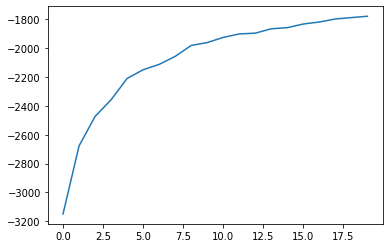

In [ ]:
x = len(elbo_hist)
#y = len(d_loss_hist)
x = np.arange(x)
#xg = np.polyfit(x, g_loss_hist, 3)

plt.plot(x, elbo_hist)
#plt.plot(x, d_loss_hist)
plt.savefig('/content/drive/My Drive/ml_logs/vae_elbo_loss.png')
plt.show()